# LSTM-InfoGAN for sinewave+sawtooth generation with noise (3 dimension feature control)

In [1]:
import tensorflow as tf
import tensorflow_gan as tfgan
import numpy as np

import utils

from rnninfogan import LSTMTFGAN

W1118 15:25:47.615447 29028 deprecation_wrapper.py:119] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow_gan\python\contrib_utils.py:305: The name tf.estimator.tpu.TPUEstimator is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimator instead.

W1118 15:25:47.618439 29028 deprecation_wrapper.py:119] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow_gan\python\contrib_utils.py:310: The name tf.estimator.tpu.TPUEstimatorSpec is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimatorSpec instead.



### The hyperparameter setting


In [2]:
# hyperparameter setting:
hparams = tf.contrib.training.HParams(
    is_training=True,
    batch_size=50,
    buffer_size=14000,
    sequence_length=50,
    epoch=300,
    structured_continuous_dim=3,
    unstructured_continuous_noise_dims=3,
    mutual_information_penalty_weight=1.0,

    num_units=128,
    gan_loss='min_max',
    d_lr=0.00009,
    g_lr=0.0001,
    generator_train_steps=1,
    discriminator_train_steps=1,
    interval=60,
    num_eval=128
)

### Create the dataset

In [3]:
train_sequence = utils.sine_wave_plus_noise_sawtooth(seq_length=hparams.sequence_length, 
                                 num_samples=hparams.buffer_size,
                                 amplitude_low=0.1, amplitude_high=2.0
                                 )
train_dataset = tf.data.Dataset.from_tensor_slices(train_sequence).shuffle(hparams.buffer_size).batch(
        hparams.batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices(train_sequence).shuffle(hparams.buffer_size).batch(hparams.batch_size)
iterator = tf.data.make_initializable_iterator(train_dataset)
real_sequence = iterator.get_next()

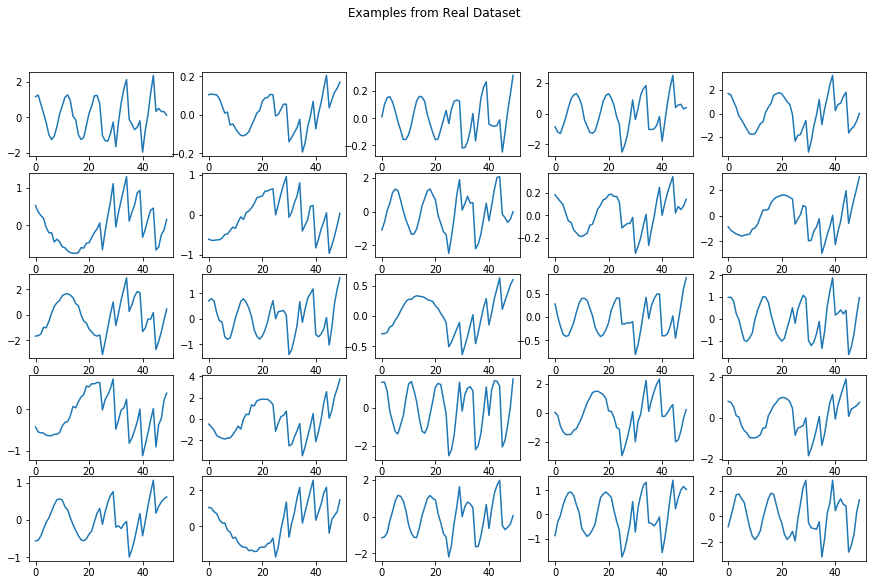

In [4]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    result = np.array(sess.run(real_sequence))

    # create the anomaly with sawwave (half sequence is sinewave, another half is the superposition of sinewave and saw wave) 
    utils.plot_sample_sequence(result, 5, 5, fig_title='Examples from Real Dataset')

### Create InfoGAN model

In [5]:
lstm_gan = LSTMTFGAN(train_dataset, hparams)

W1118 15:26:49.178672 29028 deprecation_wrapper.py:119] From D:\Code\Deep-Generative-models\rnn-tf-gan\rnninfogan.py:64: The name tf.data.make_initializable_iterator is deprecated. Please use tf.compat.v1.data.make_initializable_iterator instead.

W1118 15:26:49.184628 29028 deprecation_wrapper.py:119] From D:\Code\Deep-Generative-models\rnn-tf-gan\rnninfogan.py:197: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1118 15:26:49.190612 29028 deprecation.py:323] From D:\Code\Deep-Generative-models\rnn-tf-gan\rnninfogan.py:204: Uniform.__init__ (from tensorflow.python.ops.distributions.uniform) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W1118 15:26:49.193603 29028 deprecation.py:323] From C:\Users\jw855-admin\AppData

In [8]:
def generate_test_noise_for_infogan(sequence_length=50,
                                    unstructured_categorical_noise_dims=2,
                                    unstructured_continuous_noise_dims=3):
    num_dim_1 = 5
    num_dim_2 = 5
    cont_dim1 = np.linspace(-1.0, 1.0, num_dim_1)
    cont_dim2 = np.linspace(-1.0, 1.0, num_dim_2)

    cont_noise = []
    cat_noise = []
    for i in range(num_dim_1):
        for j in range(num_dim_2):
            cont_noise.append([0.0, cont_dim1[i], cont_dim2[j]])

    cont_noise = np.array(cont_noise, dtype=np.float32)

    unconditional_noise = np.random.normal(size=[25, sequence_length,
                                                 unstructured_continuous_noise_dims])

    unconditional_noise = np.array(unconditional_noise, dtype=np.float32)

    return unconditional_noise, cont_noise

W1118 15:27:54.571223 29028 deprecation_wrapper.py:119] From D:\Code\Deep-Generative-models\rnn-tf-gan\rnninfogan.py:227: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1118 15:27:54.614139 29028 deprecation_wrapper.py:119] From D:\Code\Deep-Generative-models\rnn-tf-gan\rnninfogan.py:228: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



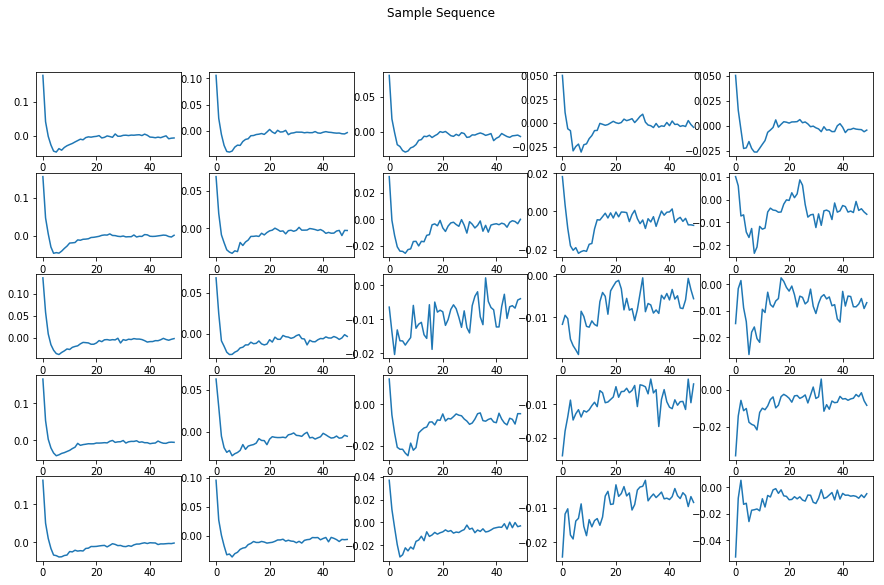

Successfully save infogan model!
Current loss: 2.360902


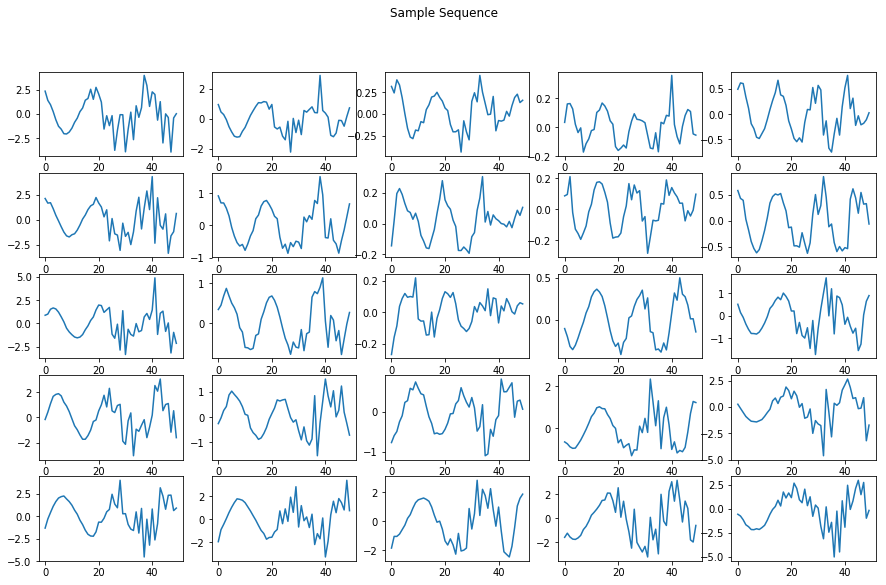

Successfully save infogan model!
Current loss: 2.314113


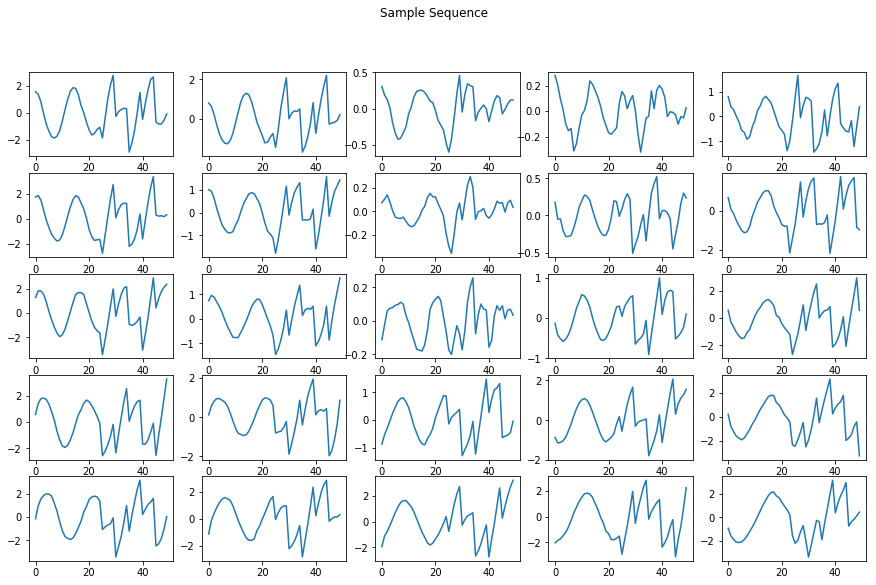

Successfully save infogan model!
Current loss: 2.367713


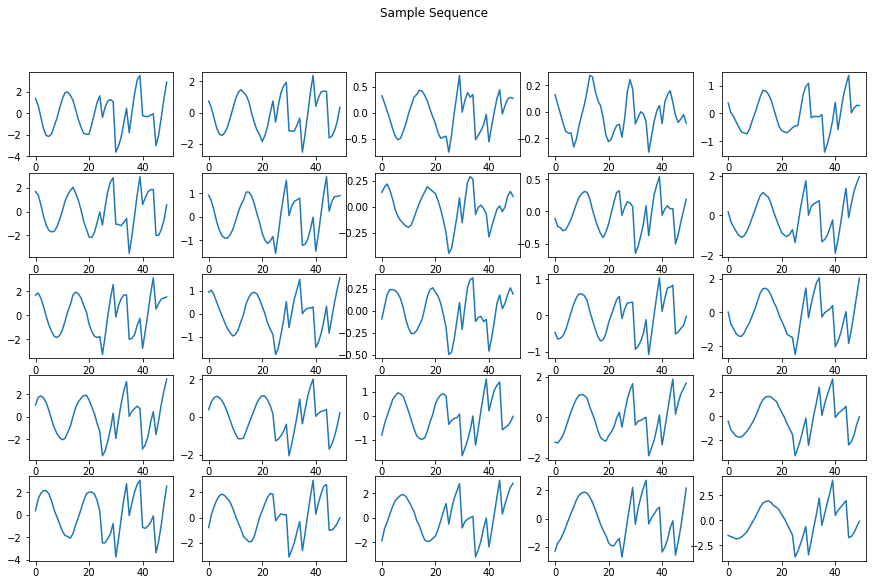

Successfully save infogan model!
Current loss: 2.337767


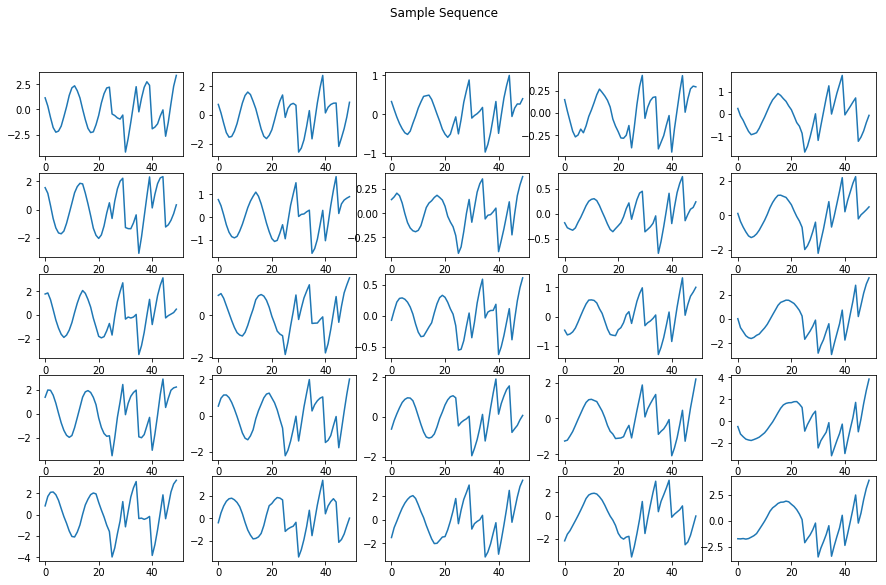

Successfully save infogan model!
Current loss: 2.316177


In [9]:
lstm_gan.train(save_path='./models/infogan_model_noisesinewave_sawtooth_', 
               test_noise_generator=generate_test_noise_for_infogan)

In [39]:
def generate_test_noise_for_infogan(sequence_length=50,
                                    unstructured_continuous_noise_dims=3):
    
    cont_dim1 = np.linspace(-1.0, 1.0, 25)

    cont_noise = []
    for i in range(25):
        cont_noise.append([ -1.0,  -1.0, cont_dim1[i]])

    cont_noise = np.array(cont_noise, dtype=np.float32)
    unconditional_noise = np.random.normal(size=[25, sequence_length,
                                                 unstructured_continuous_noise_dims])

    unconditional_noise = np.array(unconditional_noise, dtype=np.float32)

    return unconditional_noise, cont_noise

In [40]:
unconditional_noise, cont_noise = generate_test_noise_for_infogan()

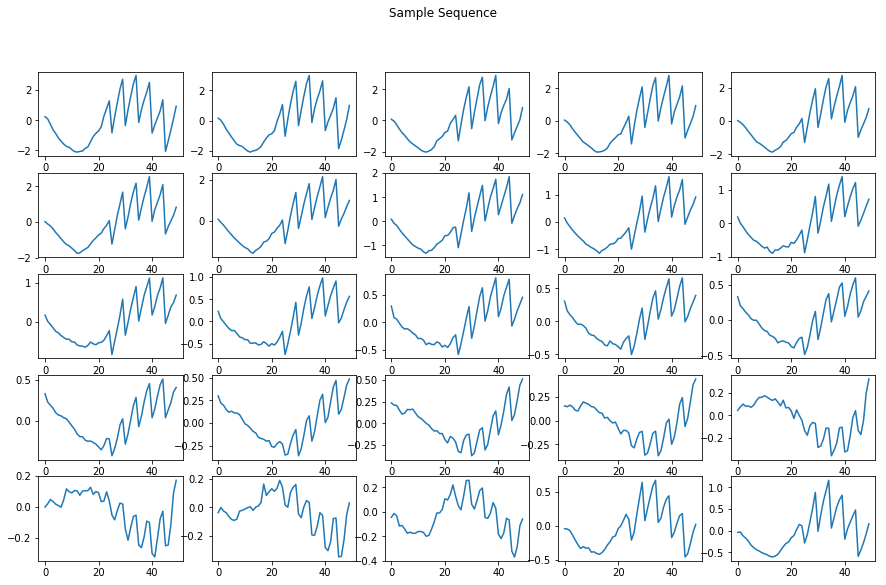

In [41]:
with tf.Session() as sess:
    lstm_gan.load_model(sess, "./models/infogan_model_noisesinewave_sawtooth_240")
    ret = lstm_gan.inference(sess, unconditional_noise, cont_noise)
    utils.plot_sequence(ret, 5, 5, fig_title='Sample Sequence')

In [42]:
def generate_test_noise_for_infogan(sequence_length=50,
                                    unstructured_continuous_noise_dims=3):
    
    cont_dim1 = np.linspace(-1.0, 1.0, 25)

    cont_noise = []
    for i in range(25):
        cont_noise.append([ -1.0, cont_dim1[i], -1.0 ])

    cont_noise = np.array(cont_noise, dtype=np.float32)
    unconditional_noise = np.random.normal(size=[25, sequence_length,
                                                 unstructured_continuous_noise_dims])

    unconditional_noise = np.array(unconditional_noise, dtype=np.float32)

    return unconditional_noise, cont_noise

In [43]:
unconditional_noise, cont_noise = generate_test_noise_for_infogan()

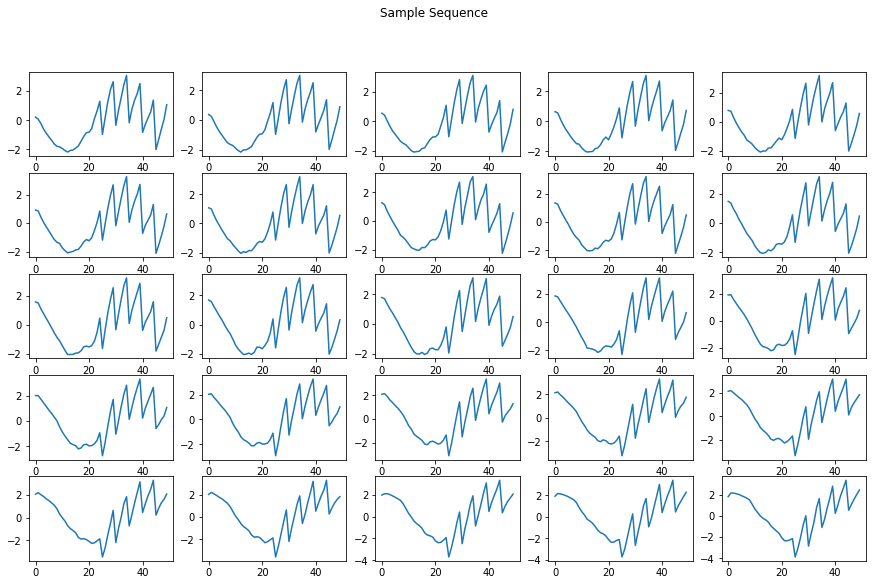

In [44]:
with tf.Session() as sess:
    lstm_gan.load_model(sess, "./models/infogan_model_noisesinewave_sawtooth_240")
    ret = lstm_gan.inference(sess, unconditional_noise, cont_noise)
    utils.plot_sequence(ret, 5, 5, fig_title='Sample Sequence')

In [45]:
def generate_test_noise_for_infogan(sequence_length=50,
                                    unstructured_continuous_noise_dims=3):
    
    cont_dim1 = np.linspace(-1.0, 1.0, 25)

    cont_noise = []
    for i in range(25):
        cont_noise.append([ cont_dim1[i], -1.0,  -1.0 ])

    cont_noise = np.array(cont_noise, dtype=np.float32)
    unconditional_noise = np.random.normal(size=[25, sequence_length,
                                                 unstructured_continuous_noise_dims])

    unconditional_noise = np.array(unconditional_noise, dtype=np.float32)

    return unconditional_noise, cont_noise

In [46]:
unconditional_noise, cont_noise = generate_test_noise_for_infogan()

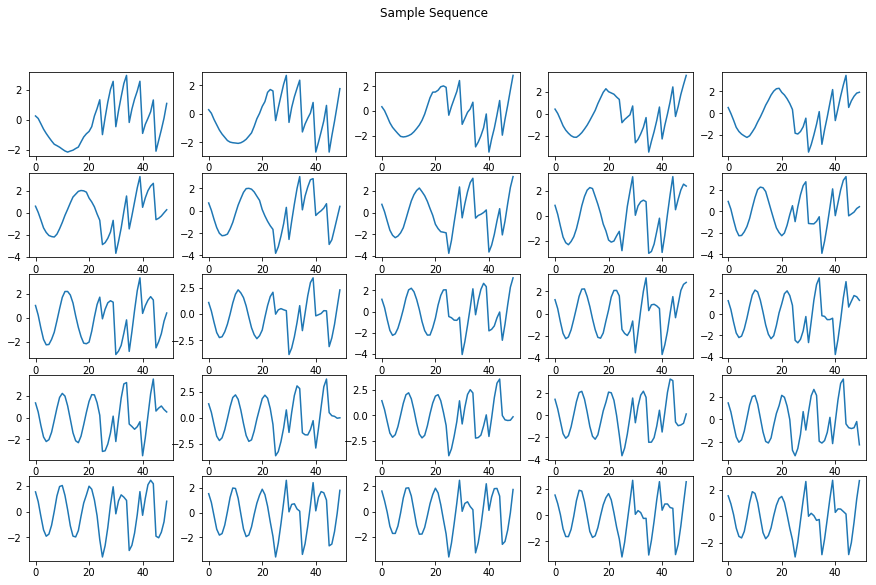

In [47]:
with tf.Session() as sess:
    lstm_gan.load_model(sess, "./models/infogan_model_noisesinewave_sawtooth_240")
    ret = lstm_gan.inference(sess, unconditional_noise, cont_noise)
    utils.plot_sequence(ret, 5, 5, fig_title='Sample Sequence')